In [1]:
# Viewing images 
import skimage 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
coins = skimage.data.coins()
cat = skimage.data.cat()
print("coins.shape:", coins.shape)
print("coins.dtype:", coins.dtype)
print("cat.shape:", cat.shape)
print("cat.dtype:", cat.dtype)

coins.shape: (303, 384)
coins.dtype: uint8
cat.shape: (300, 451, 3)
cat.dtype: uint8


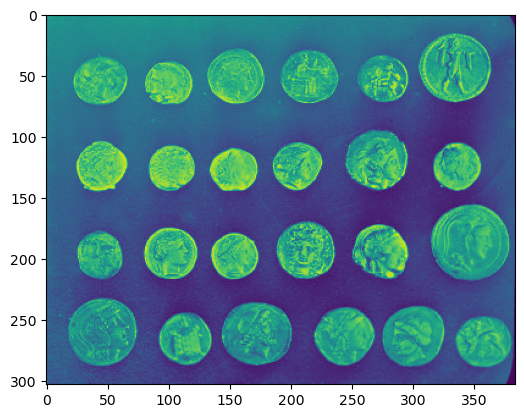

In [3]:
plt.imshow(coins)

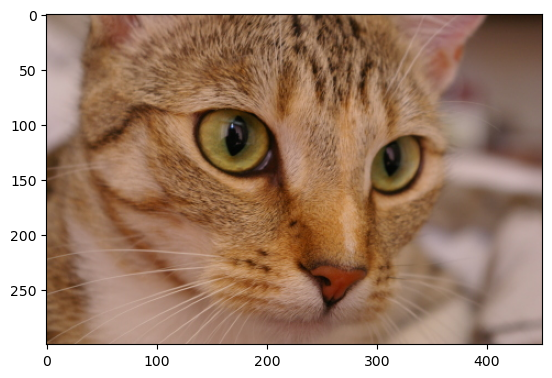

In [4]:
plt.imshow(cat)

thresh: 107


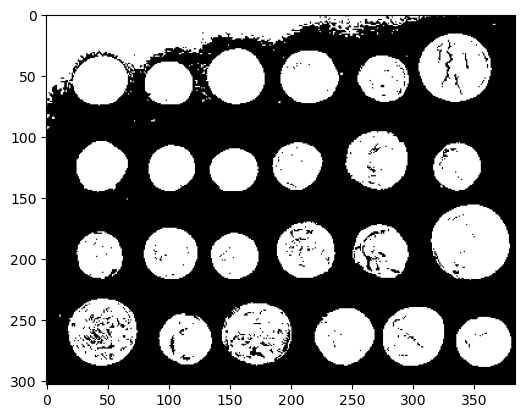

In [5]:
# Segment the coins 
from skimage.filters import threshold_otsu
thresh = threshold_otsu(coins)
print("thresh:", thresh)
binary = coins > thresh
plt.imshow(binary, cmap="gray")
# Not too good, coins still include black spots and white bit at the top not very good

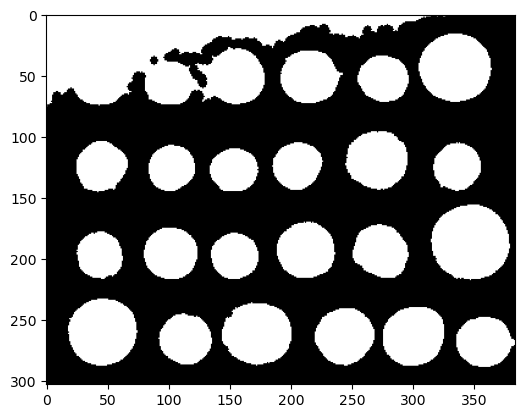

In [6]:
# Morphological operations
from skimage.morphology import binary_closing, disk, remove_small_objects

binary_closed = binary_closing(binary, disk(3))
binary_closed = remove_small_objects(binary_closed)
plt.imshow(binary_closed, cmap="gray")

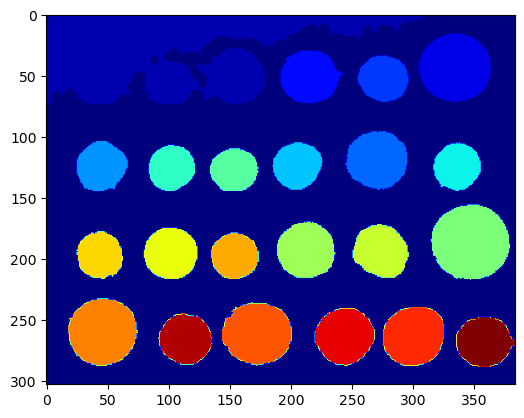

In [7]:
from skimage.morphology import label 

labels = label(binary_closed)

plt.imshow(labels, cmap="jet")

In [8]:
# Compute each region properties to get rid of the ones that are not a coin
from skimage.measure import regionprops

regions = regionprops(labels)

for lb in range(len(regions)):
    print(lb+1, regions[lb].perimeter, regions[lb].area, regions[lb].eccentricity, regions[lb].solidity)
    

1 1183.7726906832802 12849.0 0.9581910785919219 0.6982393218128464
2 188.7523086789974 2606.0 0.32942102319398286 0.9822842065586129
3 155.74621202458746 1654.0 0.42002374592409203 0.9655575014594279
4 130.2253967444162 1239.0 0.42055114889647116 0.974822974036192
5 168.3675323681471 1901.0 0.34704791642172717 0.9708886618998979
6 137.88225099390854 1328.0 0.3400989522437671 0.9672250546249089
7 129.29646455628165 1218.0 0.37631408647742237 0.9744
8 129.29646455628168 1180.0 0.2776712096865509 0.9648405560098119
9 123.39696961966999 1130.0 0.3445872751320758 0.9758203799654577
10 122.81118318204308 1104.0 0.44483889019913797 0.9769911504424779
11 212.0660171779821 3113.0 0.2896720638270349 0.976474278544542
12 156.95331880577405 1732.0 0.26025315820618755 0.9752252252252253
13 148.46803743153546 1528.0 0.4664345824971905 0.9683143219264893
14 141.0538238691624 1481.0 0.26419744754882335 0.9801455989410987
15 127.88225099390856 1135.0 0.2825007987946706 0.9626802374893978
16 125.9827560

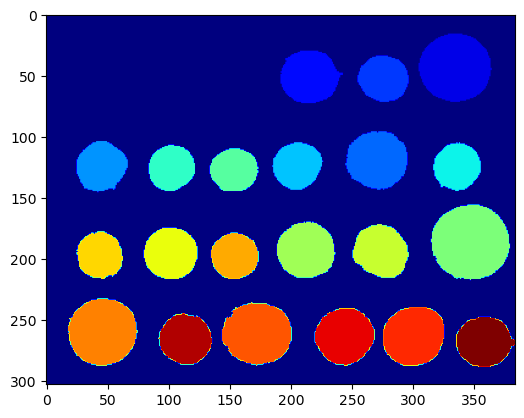

In [9]:
delete = []
for lb in range(len(regions)):
    if regions[lb].eccentricity > 0.5:
      labels[labels == lb+1] = 0
      delete.append(lb+1)

plt.imshow(labels, cmap="jet")


idx: 11


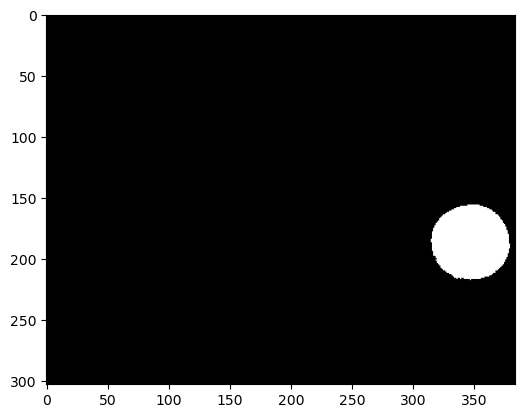

In [13]:
# Let's see the biggest one
idx = np.argmax([regions[lb].area for lb in range(len(regions)) if lb+1 not in delete])+1+len(delete)

print("idx:", idx)
plt.imshow(labels == idx, cmap="gray")

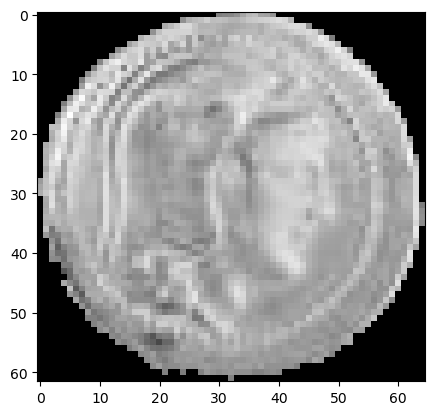

In [16]:
coin = coins * (labels == idx)
plt.imshow(coin, cmap="gray")
coin = coin[regions[idx-1].bbox[0]:regions[idx-1].bbox[2], regions[idx-1].bbox[1]:regions[idx-1].bbox[3]]
plt.imshow(coin,cmap="gray")

In [ ]:
# Lets put the coin in front of the cats, rotated 30 clockwise

(-0.5, 64.5, 61.5, -0.5)

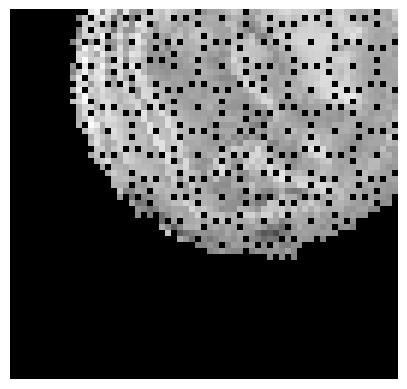

In [38]:
angle = 30*np.pi/180
R = np.array([[np.cos(angle),-np.sin(angle),0], 
[np.sin(angle),np.cos(angle),0],[0,0,1]])

coin2 = np.zeros(coin.shape)

for i in range(coin.shape[0]):
    for j in range(coin.shape[1]):
        location = np.array([i-0.5,j-0.5 ,1])
        new_location = np.dot(R,location)
        # read from coin
        if new_location[0]>=0 and new_location[0]<coin2.shape[0] and new_location[1]>=0 and new_location[1]<coin2.shape[1]: 
            coin2[int(new_location[0]),int(new_location[1])] = coin[i,j]


plt.imshow(coin2,cmap='gray') 
plt.axis('off')

[[ 1.   0.  31. ]
 [ 0.   1.  32.5]
 [ 0.   0.   1. ]]


(-0.5, 64.5, 61.5, -0.5)

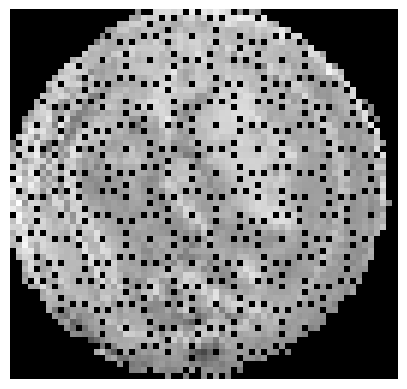

In [39]:
# Attempt 2:
T = np.array([[1,0,0.5*coin.shape[0]],[0,1,0.5*coin.shape[1]],[0,0,1]])
Tinv = np.linalg.inv(T)
coin2 = np.zeros(coin.shape)

transform=np.matmul(T,np.matmul(R,Tinv)) 
print(T)
for i in range(coin.shape[0]):
    for j in range(coin.shape[1]):
        location = np.array([i-0.5,j-0.5 ,1])
        new_location = np.dot(transform,location)
        # read from coin
        if new_location[0]>=0 and new_location[0]<coin2.shape[0] and new_location[1]>=0 and new_location[1]<coin2.shape[1]:
            coin2[int(new_location[0]),int(new_location[1])] = coin[i,j]
plt.imshow(coin2,cmap='gray') 
plt.axis('off')

/var/folders/yk/83x2smm96b9_trlwmwsyv1g00000gn/T/ipykernel_79964/4059455683.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coin2[i,j] = scipy.interpolate.interpn((np.arange(coin.shape[0]),


(-0.5, 64.5, 61.5, -0.5)

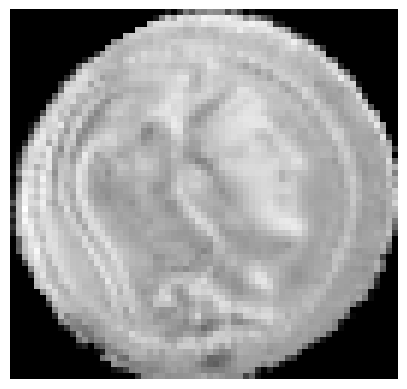

In [40]:
import scipy
coin2 = np.zeros(coin.shape) #transform=np.matmul(T,np.matmul(np.transpose(R),Tinv)) 
transform =np.linalg.inv(transform)
for i in range(coin.shape[0]):
    for j in range(coin.shape[1]):
        new_location = np.array([i-0.5,j-0.5 ,1])
        location = np.dot(transform,new_location)
        # read from coin
        if location[0]>=0 and location[0]<coin.shape[0] and location[1]>=0 and location[1]<coin.shape[1]:
            #read with linear interpolation
            coin2[i,j] = scipy.interpolate.interpn((np.arange(coin.shape[0]),
                                                    np.arange(coin.shape[1])),coin,location[0:2],method='linear',
                                                   bounds_error=False,fill_value=0) 
plt.imshow(coin2,cmap='gray')
plt.axis('off')

(-0.5, 450.5, 299.5, -0.5)

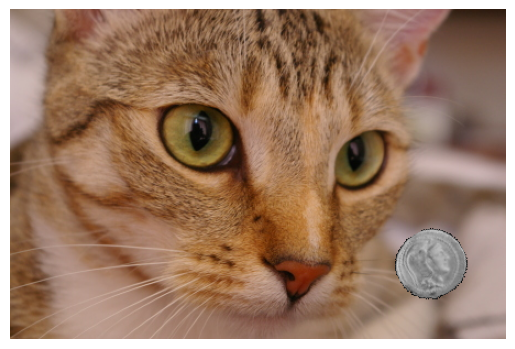

In [41]:
Tcat = np.array([[1,0,200],[0,1,350],[0,0,1]]) 
transform = np.matmul(transform,np.linalg.inv(Tcat)) 
for i in range(cat.shape[0]):
    for j in range(cat.shape[1]):
        new_location = np.array([i-0.5,j-0.5 ,1]) 
        location = np.dot(transform,new_location)
        # read from coin
        if location[0]>=0 and location[0]<coin.shape[0] and location[1]>=0 and location[1]<coin.shape[1]:
            #read with linear interpolation
            val = scipy.interpolate.interpn((np.arange(coin.shape[0]),
                                             np.arange(coin.shape[1])), coin,location[0:2],method='linear',
                                            bounds_error=False,fill_value=0) 
            if val>0:
                cat[i,j,:] = np.ones(3)*val
plt.imshow(cat,cmap='gray') 
plt.axis('off')